## Seleção de Patch de Maneira Dinâmica

In [93]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(10)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [94]:
# Realizando abertura da imagem com a bib PILLOW
path_image = "../data/base_recortada/ASC-H/10.png"
im = Image.open(path_image)
im.format, im.size, im.mode

('PNG', (180, 180), 'RGB')

In [95]:
# im = im.rotate(45)

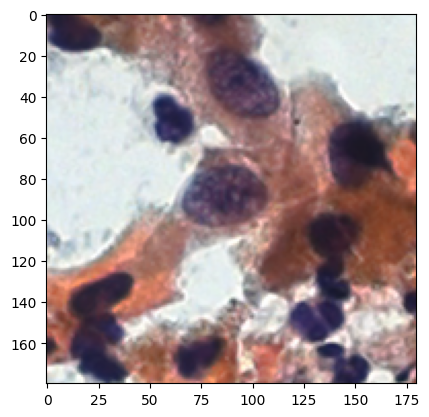

In [96]:
plt.imshow(im)
plt.show()

### Normal Pixels

In [40]:
def visualize_patch_centers(image, centers, patch_size):
    # cria o ax para plotar a img
    fig, ax = plt.subplots(1)
    
    # convert para np
    image_np = np.array(image)
    
    # normaliza a img para intervalo de 0 e 1
    if image_np.max() > 1:
        image_np = image_np / 255.0
    
    ax.imshow(image_np)
    
    patch_height, patch_width = patch_size
    
    for (h, w) in centers:
        rect = patches.Rectangle(
            (w - patch_width // 2, h - patch_height // 2), 
            patch_width, patch_height,
            linewidth=1, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        plt.plot(w, h, marker='v', color='r')
    
    # Ajusta limite das imagens para proporcao correta
    ax.set_xlim([0, image_np.shape[1]])
    ax.set_ylim([image_np.shape[0], 0])
    
    plt.show()

196
(8, 8)


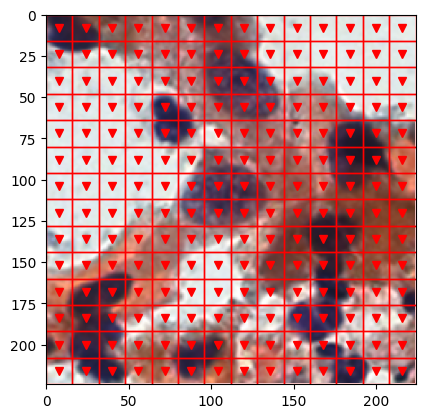

In [41]:
def generate_patch_centers(image_height, image_width, patch_size):
  
    # Stride é o espacamento entre os patches que é o próprio patch_size
    stride = patch_size  
    
    # Qtd de patches na height e no widget (SEM SOBREPOSICAO)
    num_patches_h = image_height // stride
    num_patches_w = image_width // stride
    
    centers_h = []
    centers_w = []
    
    # Todos os patches da coluna
    for i in range(num_patches_h):
      centers_h.append((i * stride + stride // 2))
    
    # Todos os patches da largura
    for j in range(num_patches_w):
      centers_w.append((j * stride + stride // 2))
    
    centers = []
    # Calculando a combinação das posicoes dos patches (X,Y)
    for h in centers_h:
      for w in centers_w:
        centers.append((h,w))
    
    # Retornar os pixels centrais
    return centers

# Variaveis
patch_size = 16
    
# Realizando resize na imagem com a bib PIL para 224x224
resized_image = im.resize((224,224))
centers = generate_patch_centers(224, 224, patch_size)
print(len(centers))
print(centers[0])

# Printa a visualizacao da imagem
visualize_patch_centers(resized_image, centers, (patch_size, patch_size))

-----

### Random Pixels

In [101]:
def generate_random_patch_centers(image_height, image_width, patch_size, num_patches):
    patch_height, patch_width = patch_size
    
    centers = []
    for _ in range(num_patches):
        h = random.uniform(patch_height / 2, image_height - patch_height / 2)
        w = random.uniform(patch_width / 2, image_width - patch_width / 2)
        centers.append((h, w))

    return centers

196
[(195.83549957272788, 193.89943803233456), (158.68397621990644, 63.99003210676355), (50.057073588405245, 62.606547865121286), (94.60071529169747, 127.3744466157692), (123.1995685321854, 29.058493552953976), (52.330622285904326, 41.53443126827054), (100.05630258511728, 135.89957463526747), (15.975788390848264, 121.65556170397447), (16.46637547134649, 126.09674422449706), (12.69825043768493, 116.12232315012535), (172.30532091937877, 48.96406685204301), (48.2568467071639, 181.8431396557139), (88.67010958786655, 154.40749290888283), (54.79340092195642, 177.78670020723692), (184.5883832244852, 129.01554160566351), (179.5527557775987, 77.0894559196489), (83.2404933972626, 108.08345489910694), (80.52774676418014, 140.11916726422953), (17.58374351007123, 118.43926684713236), (127.7015833895141, 124.87897323157532), (132.83652616636618, 57.747889820332375), (27.96674639641673, 41.09707000527998), (77.62556365712601, 113.39782767357407), (89.12861395423181, 170.12850175930149), (42.486450919

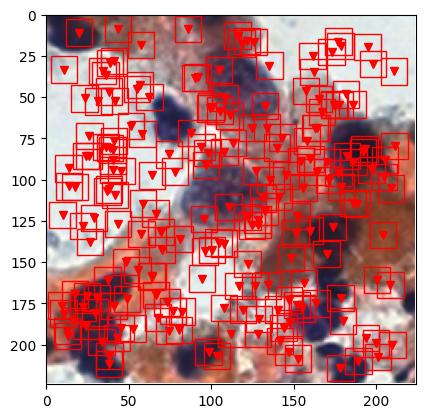

In [108]:
image_height = 224
image_width = 224
patch_size = (16, 16)
num_patches = 196
resized_image = im.resize((224,224))

patch_centers = generate_random_patch_centers(image_height, image_width, patch_size, num_patches)

# patch_centers = patch_centers[0:2]

print(len(patch_centers))
print(patch_centers)
visualize_patch_centers(resized_image, patch_centers, (16, 16))

---

### Random Pixels (Melhorado)

196
[(200.7249861321487, 40.73471888461968), (107.57838869754197, 20.702821428688623), (108.96550482106545, 48.509296305763215), (66.16817521418261, 48.18879276649286), (193.88136343681532, 113.64728166432434), (107.75337667677265, 111.76003228722458), (194.58421879600263, 54.23345196781182), (50.14189706826664, 46.77144498335204), (181.8807813780197, 126.39498653764463), (42.463716891886534, 16.641985299661116), (23.60034452931361, 148.87633301410963), (182.54380158084987, 65.23663367798895), (62.750811919906496, 162.01922212400908), (120.80815696694212, 171.29211294059974), (77.30758647723418, 174.4095269163259), (49.900795470470115, 114.46798482417705), (198.07787538451478, 127.63764262414097), (90.23238311823675, 110.90322771784558), (214.60130314655922, 143.91842699932468), (36.173727070378355, 58.57655260931226), (64.26782674034604, 38.798564930480616), (24.284626229617153, 30.553530112321184), (91.06352754280653, 80.78561428951753), (93.58032534762376, 21.075983922415247), (162.

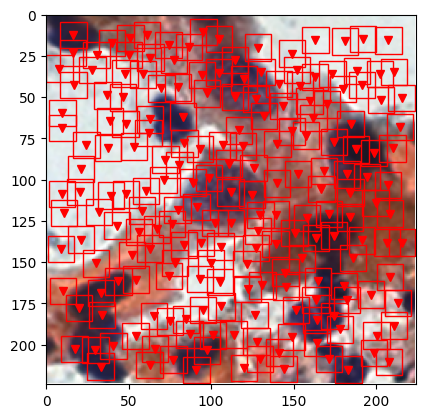

In [99]:
def pixels_adj(matriz, x, y, n_voltas):
    coords_voltas = []
    n_linhas, n_colunas = matriz.shape
    
    for volta in range(1, n_voltas + 1):
        for i in range(-volta, volta + 1):
            if 0 <= y + i < n_linhas:
                if 0 <= x - volta < n_colunas:
                    coords_voltas.append((y + i, x - volta))
                if 0 <= x + volta < n_colunas:
                    coords_voltas.append((y + i, x + volta))
        
        for j in range(-volta + 1, volta):
            if 0 <= x + j < n_colunas:
                if 0 <= y - volta < n_linhas:
                    coords_voltas.append((y - volta, x + j))
                if 0 <= y + volta < n_linhas:
                    coords_voltas.append((y + volta, x + j))
    coords_voltas.append((y,x))
    return coords_voltas

def verificar_adj(matriz, x, y, lista_centros):
    x, y = int(round(x)), int(round(y))  # Converta para inteiros
    if len(lista_centros) == 0:
        return False
    else:
        for each in lista_centros:
            each_x, each_y = int(round(each[1])), int(round(each[0]))
            ret = pixels_adj(matriz=matriz, x=each_x, y=each_y, n_voltas=8)
            if (y, x) in ret:  # Verifique na ordem correta
                return True
    return False

def random_patchs_melhorados(image_height, image_width, patch_size, num_patches, img_PIL):
    patch_height, patch_width = patch_size
    
    img_gray = img_PIL.convert('L')
    img_mtx = np.array(img_gray)
    
    centers = []
    
    for _ in range(num_patches):
        h = random.uniform(patch_height / 2, image_height - patch_height / 2)
        w = random.uniform(patch_width / 2, image_width - patch_width / 2)
        
        
        check = verificar_adj(img_mtx, w, h, centers)
        
        while check:
            h = random.uniform(patch_height / 2, image_height - patch_height / 2)
            w = random.uniform(patch_width / 2, image_width - patch_width / 2)
            check = verificar_adj(img_mtx, w, h, centers)
        
        centers.append((h, w))
    
    return centers

# Uso do código
image_height = 224
image_width = 224
patch_size = (16, 16)
num_patches = 196
imagem_rgb = im.convert('RGB')
resized_image = imagem_rgb.resize((224, 224))

patch_centers = random_patchs_melhorados(image_height, image_width, patch_size, num_patches, resized_image)

print(len(patch_centers))
print(patch_centers)
visualize_patch_centers(resized_image, patch_centers, (16, 16))